<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/5K_100D_GLOVE_NN_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv 
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mental_health_data/full_mental_health_df.csv')

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 215146 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (152966, 250)


In [ ]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (152966, 12)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(137669, 250) (137669, 12)
(15297, 250) (15297, 12)


In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM,SpatialDropout1D,MaxPooling1D,Conv1D,Flatten,Dropout
from keras.models import Model

In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-07-23 08:05:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-23 08:05:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-23 08:05:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
#wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  100


In [ ]:
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

#LSTM 100


In [ ]:

target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

lstm =LSTM(100,return_sequences=False)(target_embedding)

label= Dense(12,activation='softmax')(lstm)

model = Model(inputs=target_input, outputs=label) 
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()




Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) multiple                  40000100  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1212      
Total params: 40,081,712
Trainable params: 81,612
Non-trainable params: 40,000,100
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 500s 2s/step - loss: 1.7196 - accuracy: 0.4243 - val_loss: 1.3519 - val_accuracy: 0.5315
Epoch 2/10
269/269 [==============================] - 484s 2s/step - loss: 1.2632 - accuracy: 0.5718 - val_loss: 1.1051 - val_accuracy: 0.6168
Epoch 3/10
269/269 [==============================] - 480s 2s/step - loss: 1.0622 - accuracy: 0.6336 - val_loss: 0.9964 - val_accuracy: 0.6508
Epoch 4/10
269/269 [==============================] - 480s 2s/step - loss: 0.9634 - accuracy: 0.6644 - val_loss: 0.9315 - val_accuracy: 0.6705
Epoch 5/10
269/269 [==============================] - 476s 2s/step - loss: 0.8862 - accuracy: 0.6880 - val_loss: 0.8626 - val_accuracy: 0.6899
Epoch 6/10
269/269 [==============================] - 473s 2s/step - loss: 0.8295 - accuracy: 0.7038 - val_loss: 0.8184 - val_accuracy: 0.7057
Epoch 7/10
269/269 [==============================] - 472s 2s/step - loss: 0.7886 - accuracy: 0.7199 - val_loss: 0.7877 - val_accuracy: 0.7137

In [ ]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.7484
Testing Accuracy:  0.7318


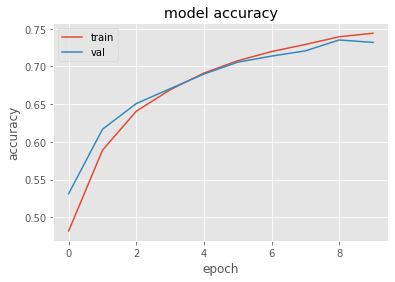

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model.predict(X_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(rounded_predictions, axis=1)
rounded_predictions[1]
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[1594,    1,   13,  419,   11,    8,   17,    2,    5,    4,   16,
           3],
       [  23,   42,    7,   82,    3,    1,    4,    1,    2,    8,    5,
           0],
       [  11,    2,  553,  114,   14,    5,   21,    2,    0,    4,   12,
           4],
       [ 222,    6,   37, 4905,   24,    5,   50,    1,    6,    9,  566,
           1],
       [  16,    0,   47,   88, 1547,    7,   15,    2,    0,    2,    3,
           0],
       [  18,    0,   22,   46,   13,  387,    3,    0,    0,    3,    3,
           0],
       [  20,    1,   25,   85,   14,    2,  757,    1,    1,    0,    2,
           3],
       [   7,    0,   26,   15,    4,    0,    6,   86,    0,    2,    0,
           2],
       [  33,    2,    2,   58,    2,    1,    6,    0,  107,    2,    6,
           0],
       [  24,    3,   13,   85,    3,    3,    8,    0,    2,   77,   10,
           0],
       [  45,    1,   19, 1416,    6,    2,   18,    0,    6,    1, 1067,
           0],
       [   4,    0,  

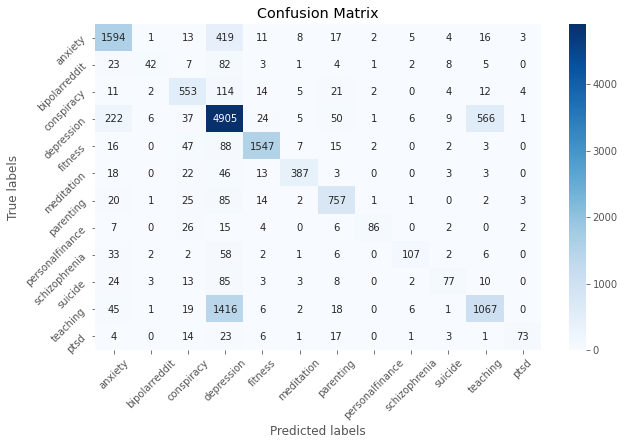

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#CNN


In [ ]:

target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(16,3,activation='relu')(target_embedding)

global_average=GlobalAveragePooling1DMasked()(convolution)

label= Dense(12,activation='softmax')(global_average)

model2 = Model(inputs=target_input, outputs=label) 
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) multiple                  40000100  
_________________________________________________________________
conv1d (Conv1D)              (None, 248, 16)           4816      
_________________________________________________________________
global_average_pooling1d_mas (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                204       
Total params: 40,005,120
Trainable params: 5,020
Non-trainable params: 40,000,100
_________________________________________________________________


In [ ]:
history = model2.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 50s 181ms/step - loss: 2.1155 - accuracy: 0.3037 - val_loss: 1.7389 - val_accuracy: 0.4279
Epoch 2/10
269/269 [==============================] - 48s 180ms/step - loss: 1.6854 - accuracy: 0.4363 - val_loss: 1.5817 - val_accuracy: 0.4677
Epoch 3/10
269/269 [==============================] - 48s 180ms/step - loss: 1.5586 - accuracy: 0.4707 - val_loss: 1.5042 - val_accuracy: 0.4860
Epoch 4/10
269/269 [==============================] - 48s 180ms/step - loss: 1.4894 - accuracy: 0.4920 - val_loss: 1.4621 - val_accuracy: 0.4992
Epoch 5/10
269/269 [==============================] - 48s 177ms/step - loss: 1.4550 - accuracy: 0.5055 - val_loss: 1.4349 - val_accuracy: 0.5081
Epoch 6/10
269/269 [==============================] - 48s 178ms/step - loss: 1.4223 - accuracy: 0.5176 - val_loss: 1.4153 - val_accuracy: 0.5168
Epoch 7/10
269/269 [==============================] - 48s 177ms/step - loss: 1.4078 - accuracy: 0.5232 - val_loss: 1.3977 - val_ac

In [ ]:
loss, accuracy = model2.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5415
Testing Accuracy:  0.5340


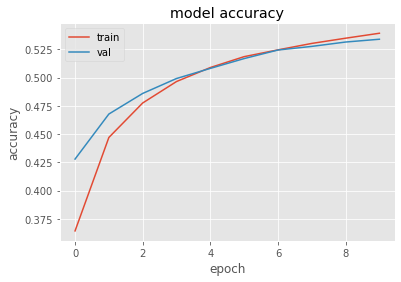

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model.predict(X_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(rounded_predictions, axis=1)
rounded_predictions[1]
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[1594,    1,   13,  419,   11,    8,   17,    2,    5,    4,   16,
           3],
       [  23,   42,    7,   82,    3,    1,    4,    1,    2,    8,    5,
           0],
       [  11,    2,  553,  114,   14,    5,   21,    2,    0,    4,   12,
           4],
       [ 222,    6,   37, 4905,   24,    5,   50,    1,    6,    9,  566,
           1],
       [  16,    0,   47,   88, 1547,    7,   15,    2,    0,    2,    3,
           0],
       [  18,    0,   22,   46,   13,  387,    3,    0,    0,    3,    3,
           0],
       [  20,    1,   25,   85,   14,    2,  757,    1,    1,    0,    2,
           3],
       [   7,    0,   26,   15,    4,    0,    6,   86,    0,    2,    0,
           2],
       [  33,    2,    2,   58,    2,    1,    6,    0,  107,    2,    6,
           0],
       [  24,    3,   13,   85,    3,    3,    8,    0,    2,   77,   10,
           0],
       [  45,    1,   19, 1416,    6,    2,   18,    0,    6,    1, 1067,
           0],
       [   4,    0,  

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(rounded_labels, rounded_predictions,labels=labels))

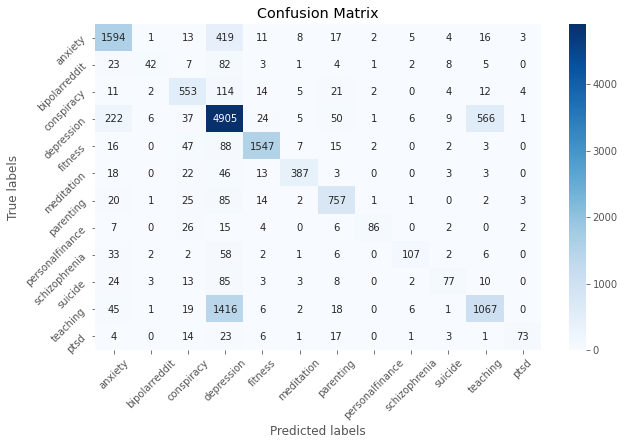

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#LSTM+CNN


In [ ]:
target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(16,3,activation='relu')(target_embedding)

#global_average=GlobalAveragePooling1DMasked()(convolution)

lstm =LSTM(100,return_sequences=False)(convolution)

label= Dense(12,activation='softmax')(lstm)

model3 = Model(inputs=target_input, outputs=label) 
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) multiple                  40000100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 16)           4816      
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_4 (Dense)              (None, 12)                1212      
Total params: 40,052,928
Trainable params: 52,828
Non-trainable params: 40,000,100
_________________________________________________________________


In [ ]:
history = model3.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 491s 2s/step - loss: 1.8041 - accuracy: 0.3933 - val_loss: 1.4512 - val_accuracy: 0.5009
Epoch 2/10
269/269 [==============================] - 479s 2s/step - loss: 1.4363 - accuracy: 0.5135 - val_loss: 1.3363 - val_accuracy: 0.5383
Epoch 3/10
269/269 [==============================] - 443s 2s/step - loss: 1.2948 - accuracy: 0.5561 - val_loss: 1.2292 - val_accuracy: 0.5795
Epoch 4/10
269/269 [==============================] - 480s 2s/step - loss: 1.1988 - accuracy: 0.5921 - val_loss: 1.1941 - val_accuracy: 0.5907
Epoch 5/10
269/269 [==============================] - 477s 2s/step - loss: 1.1550 - accuracy: 0.6056 - val_loss: 1.1232 - val_accuracy: 0.6106
Epoch 6/10
269/269 [==============================] - 482s 2s/step - loss: 1.1057 - accuracy: 0.6215 - val_loss: 1.0955 - val_accuracy: 0.6239
Epoch 7/10
269/269 [==============================] - 492s 2s/step - loss: 1.0544 - accuracy: 0.6393 - val_loss: 1.0558 - val_accuracy: 0.6346

In [ ]:
loss, accuracy = model3.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6686
Testing Accuracy:  0.6585


In [ ]:
#Without dropout 
#Training Accuracy: 0.8978
#Testing Accuracy:  0.7545



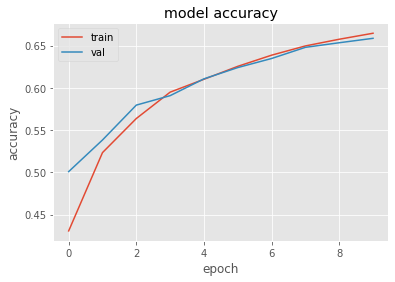

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions3 = model3.predict(X_test, batch_size=128, verbose=0)
rounded_predictions3=np.argmax(rounded_predictions3, axis=1)
rounded_predictions3[1]
rounded_labels3=np.argmax(Y_test, axis=1)
rounded_labels3[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm3 = confusion_matrix(rounded_labels3, rounded_predictions3)
cm3

array([[1350,    0,   53,  552,   52,   22,   34,    0,    0,    0,   30,
           0],
       [  18,    0,   20,  108,   11,    3,    9,    0,    0,    0,    9,
           0],
       [   8,    0,  541,  100,   48,    4,   32,    3,    0,    0,    6,
           0],
       [ 183,    0,  114, 4698,  106,   18,   94,    2,    0,    0,  617,
           0],
       [   9,    0,  102,   87, 1456,   17,   38,   16,    0,    0,    2,
           0],
       [  20,    0,   35,   74,   49,  280,   32,    3,    0,    0,    2,
           0],
       [  13,    0,   65,   93,   21,    4,  711,    2,    0,    0,    2,
           0],
       [   1,    0,   74,   14,   19,    1,   32,    7,    0,    0,    0,
           0],
       [  38,    0,   19,  106,    7,    5,   33,    0,    0,    0,   11,
           0],
       [  27,    0,   35,  115,   14,    4,   18,    1,    0,    0,   14,
           0],
       [  37,    0,   39, 1414,   26,    6,   28,    1,    0,    0, 1030,
           0],
       [   2,    0,  

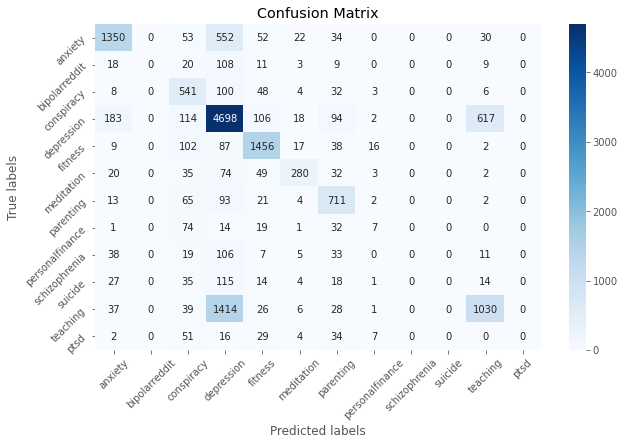

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm3, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);